# **Basics**

In [14]:
# Librerías ocupadas

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn para la manipulación de datos y métricas
from sklearn.model_selection import train_test_split   # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.datasets import load_iris                 # Para cargar el conjunto de datos de Iris
from sklearn.metrics import roc_auc_score              # Para calcular el ROC AUC

# Importar módulos de PyTorch para la creación y entrenamiento de redes neuronales
import torch                       # Biblioteca PyTorch
import torch.nn as nn              # Módulo de redes neuronales
import torch.nn.functional as F    # Funciones de activación y otras operaciones para redes neuronales
import torch.optim as optim        # Algoritmos de optimización
from torch.utils.data import DataLoader, TensorDataset  # Para crear datasets y data loaders personalizados

# Importar módulos de imbalanced-learn para manejar el desbalance de clases
from imblearn.over_sampling import RandomOverSampler

# Importar módulos específicos de Lumin para la configuración de gráficos
from lumin.plotting.plot_settings import PlotSettings

# Importar módulos adicionales
from pathlib import Path  # Para manipulación de rutas de archivos


In [15]:
# Configuración de estilo de seaborn para la visualización
sns.set_style("whitegrid")

In [16]:
# Configuración para las gráficas
plot_settings = PlotSettings(cat_palette='tab10', savepath=Path('.'), format='.pdf')

In [17]:
# Función para calcular el puntaje de prueba
def score_test_df(df:pd.DataFrame, cut:float, public_wgt_factor:float=1, private_wgt_factor:float=1, verbose:bool=True):
    """
    Calcula el puntaje de prueba de un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame con las predicciones y otros datos relevantes.
        cut (float): Umbral de corte para las predicciones.
        public_wgt_factor (float): Factor de peso para el cálculo del AMS público.
        private_wgt_factor (float): Factor de peso para el cálculo del AMS privado.
        verbose (bool): Indica si se mostrará información detallada.
    
    Returns:
        public_ams (float): Puntaje AMS público.
        private_ams (float): Puntaje AMS privado.
    """
    accept = (df.pred >= cut)
    signal = (df.gen_target == 1)
    bkg = (df.gen_target == 0)
    public = (df.private == 0)
    private = (df.private == 1)

    public_ams = calc_ams(public_wgt_factor*np.sum(df.loc[accept & public & signal, 'gen_weight']),
                          public_wgt_factor*np.sum(df.loc[accept & public & bkg, 'gen_weight']))

    private_ams = calc_ams(private_wgt_factor*np.sum(df.loc[accept & private & signal, 'gen_weight']),
                           private_wgt_factor*np.sum(df.loc[accept & private & bkg, 'gen_weight']))

    if verbose: print("Public:Private AMS: {} : {}".format(public_ams, private_ams))    
    return public_ams, private_ams


# **Model**

In [18]:
import torch.nn as nn
from torchvision import models

In [19]:
# Cargar el modelo pre-entrenado ResNet-18
model_res = models.resnet18(pretrained=True)

# Obtener el número de características en la capa de clasificación del modelo pre-entrenado
num_features = model_res.fc.in_features

# Reemplazar la capa de clasificación (fully connected) con una nueva capa lineal para adaptarla a un problema de clasificación con 3 clases
model_res.fc = nn.Linear(num_features, 3)

# **Train**

In [20]:
import copy
import time
import torch
import torch.nn as nn

In [66]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, num_epochs, scheduler = None):
    """
    Función para entrenar un modelo de red neuronal.

    Args:
        model (torch.nn.Module): Modelo de red neuronal a entrenar.
        dataloaders (dict): Diccionario que contiene los dataloaders para entrenamiento y validación.
        dataset_sizes (dict): Diccionario que contiene el tamaño de los conjuntos de datos de entrenamiento y validación.
        criterion: Función de pérdida.
        optimizer: Optimizador.
        device: Dispositivo de cómputo (CPU o GPU) para entrenamiento.
        scheduler: (Opcional) Scheduler para ajustar la tasa de aprendizaje.
        num_epochs (int): Número de épocas de entrenamiento (por defecto: 1).

    Returns:
        model (torch.nn.Module): Modelo entrenado.
    """
    start_time = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch + 1}/{num_epochs}:")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            
            # Set model mode (train/eval)
            model.train(phase == 'train')
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and scheduler:
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # Deep copy the model if validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        
        print()
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {(total_time // 60):.0f}m {(total_time % 60):.0f}s")
    print(f"BEST VALIDATION ACCURACY: {best_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model

In [69]:
import time

def train_model_Vit(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0  # Variable para almacenar la mejor precisión de validación
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {running_loss/len(train_loader)}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.long)
                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            print(f"Validation Accuracy: {val_accuracy}")
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

        print('-' * 10)

    print("Training completed.")
    print(f"BEST VALIDATION ACCURACY: {best_val_accuracy:.4f}")

# **Data Cleaning**

In [22]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [23]:
def clean_data(data):
    """
    Limpia y preprocesa los datos, aplicando sobremuestreo con SMOTE para equilibrar las clases.
    
    Args:
        data (pd.DataFrame): DataFrame con los datos a limpiar.
    
    Returns:
        df_scaled (pd.DataFrame): DataFrame con los datos limpios, normalizados y clases equilibradas.
    """
    # Copia de los datos originales para preservarlos
    df = data.copy()
    
    # Aplicar sobremuestreo con SMOTE para equilibrar las clases
    X = df.drop(columns=['Potability'])  # Ajusta 'Potability' al nombre de tu columna objetivo
    y = df['Potability']                  # Ajusta 'Potability' al nombre de tu columna objetivo
    
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Reconstruir el DataFrame después del sobremuestreo
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                              pd.Series(y_resampled, name='Potability')], axis=1)
    
    # Imputación de valores faltantes
    imputer = IterativeImputer()
    df_imputed = pd.DataFrame(imputer.fit_transform(df_resampled), columns=df_resampled.columns)

    # Detección y eliminación de valores atípicos
    clf = IsolationForest(random_state=0)
    outliers = clf.fit_predict(df_imputed.select_dtypes(include=['float64', 'int64']))
    df_cleaned = df_imputed[outliers == 1]

    # Normalización de los datos
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned.select_dtypes(include=['float64', 'int64'])), 
                             columns=df_cleaned.select_dtypes(include=['float64', 'int64']).columns)
    
    return df_scaled

# **Data Preparation**

In [24]:
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
import numpy as np

In [25]:
# Inserción de datos en imagen 
def data_to_image(data):
    """
    Convierte datos en imágenes.
    
    Args:
        data (list): Lista de datos.
    
    Returns:
        np.array: Matriz numpy que representa las imágenes.
    """
    data_images = []
    font = ImageFont.truetype("arial.ttf", size=20)
    for dat in data:
        background = np.array([[0 for _ in range(255)] for _ in range(255)], dtype='uint8')
        image = Image.fromarray(background)
        draw = ImageDraw.Draw(image)
        draw.text((40, 190), str(dat[0]), fill='white', font=font)
        draw.text((120, 190), str(dat[1]), fill='white', font=font)
        draw.text((190, 190), str(dat[2]), fill='white', font=font)
        
        draw.text((40, 120), str(dat[3]), fill='white', font=font)
        draw.text((120, 120), str(dat[4]), fill='white', font=font)
        draw.text((190, 120), str(dat[5]), fill='white', font=font)
        
        draw.text((40, 40), str(dat[6]), fill='white', font=font)
        draw.text((110, 40), str(dat[7]), fill='white', font=font)
        draw.text((190, 40), str(dat[8]), fill='white', font=font)
        
        rgb = [np.array(image, dtype='uint8') for _ in range(3)]
        data_images.append(rgb)
    return np.array(data_images) / 255

In [43]:
# Barra de grises
def data_to_heatmap_bw(data):
    data_heatmaps = []

    # Normalizar min-max
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)
    min_max_normalized = (data - min_values) / (max_values - min_values)

    # Crear un colormap personalizado en escala de grises
    cmap = sns.color_palette("Greys", as_cmap=True)

    for row in min_max_normalized:
        # Obtener el número de características
        num_features = len(row)

        # Crear un mapa de calor utilizando Seaborn
        ax = sns.heatmap(data=np.expand_dims(row, axis=0), cmap=cmap, cbar=False, square=True)
        ax.set_xticks(np.arange(num_features) + 0.5, minor=False)
        ax.set_xticklabels(np.arange(1, num_features + 1), minor=False)
        ax.set_yticks([])  # Desactivar las etiquetas de los ejes y
        heatmap_image = np.array(ax.get_figure().canvas.renderer.buffer_rgba())

        # Ajustar el orden de los grupos de colores
        if len(data_heatmaps) % 2 == 1:
            heatmap_image = heatmap_image[:, ::-1, :]

        data_heatmaps.append(heatmap_image)

    return np.array(data_heatmaps) / 255

In [56]:
# Conversión de datos a imágenes en escala de grises con 3 canales (En cuadrilla)
def gray_gang_gg(data):
    cell_size = 85
    rgb_images = []
    for row in data:
        image = np.zeros((255, 255, 3), dtype=np.uint8)
        for i, value in enumerate(row):
            x = (i % 3) * cell_size
            y = (i // 3) * cell_size
            grayscale_value = int(value * 255)
            image[y:y+cell_size, x:x+cell_size] = [grayscale_value] * 3
        rgb_images.append(image)
    return np.array(rgb_images)

In [73]:
# PCA Function
def data_to_image_pca(data):
    data_images = []
    num_components = 3  # Number of principal components
    pca = PCA(n_components=num_components)
    data_pca = pca.fit_transform(data)

    for dat in data_pca:
        scaled_dat = ((dat - dat.min()) / (dat.max() - dat.min())) * 255
        image = Image.new("RGB", (255, 255))
        draw = ImageDraw.Draw(image)
        for i in range(len(scaled_dat)):
            x = scaled_dat[i]
            y = 150  # Adjust this vertical position as needed
            draw.rectangle([x-1, y-1, x+1, y+1], fill='white')
        data_images.append(np.array(image))
    
    return np.array(data_images)

# **T0**

In [27]:
# Disabling cudnn for deterministic results
torch.backends.cudnn.enabled = False

# Selecting the device for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the autoreload extension to automatically reload modules
%load_ext autoreload

# Setting autoreload to automatically reload all modules
%autoreload 2

# Setting matplotlib to display plots inline in the Jupyter Notebook
%matplotlib inline

# Setting the figure format for inline plotting to 'retina' for better quality
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [29]:
df = pd.read_csv('../data/drinking_water_potability.csv')
df.tail(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.17706,7.509306,333.775777,327.459761,16.140368,78.698446,2.309149,1


In [30]:
df_cleaned = clean_data(df)
df_cleaned

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.466496,0.538858,0.396489,0.515171,0.607263,0.669439,0.251081,0.699753,0.306355,0.0
1,0.188638,0.229369,0.353777,0.451496,0.462049,0.719411,0.451691,0.450999,0.617647,0.0
2,0.550590,0.618194,0.379063,0.704357,0.462049,0.414652,0.522262,0.532866,0.325143,0.0
3,0.568563,0.577747,0.420740,0.587863,0.558649,0.317880,0.587787,0.808065,0.643585,0.0
4,0.632600,0.441300,0.340910,0.443007,0.363236,0.379337,0.300332,0.253606,0.531482,0.0
...,...,...,...,...,...,...,...,...,...,...
3539,0.487644,0.424335,0.391671,0.524607,0.551578,0.809093,0.489516,0.649463,0.613577,1.0
3540,0.517059,0.213649,0.635107,0.576354,0.407959,0.512183,0.549762,0.423245,0.692120,1.0
3541,0.335455,0.627784,0.222100,0.448721,0.462049,0.376690,0.278169,0.600486,0.695354,1.0
3542,0.470389,0.487349,0.444984,0.514232,0.494689,0.307259,0.350640,0.495031,0.423521,1.0


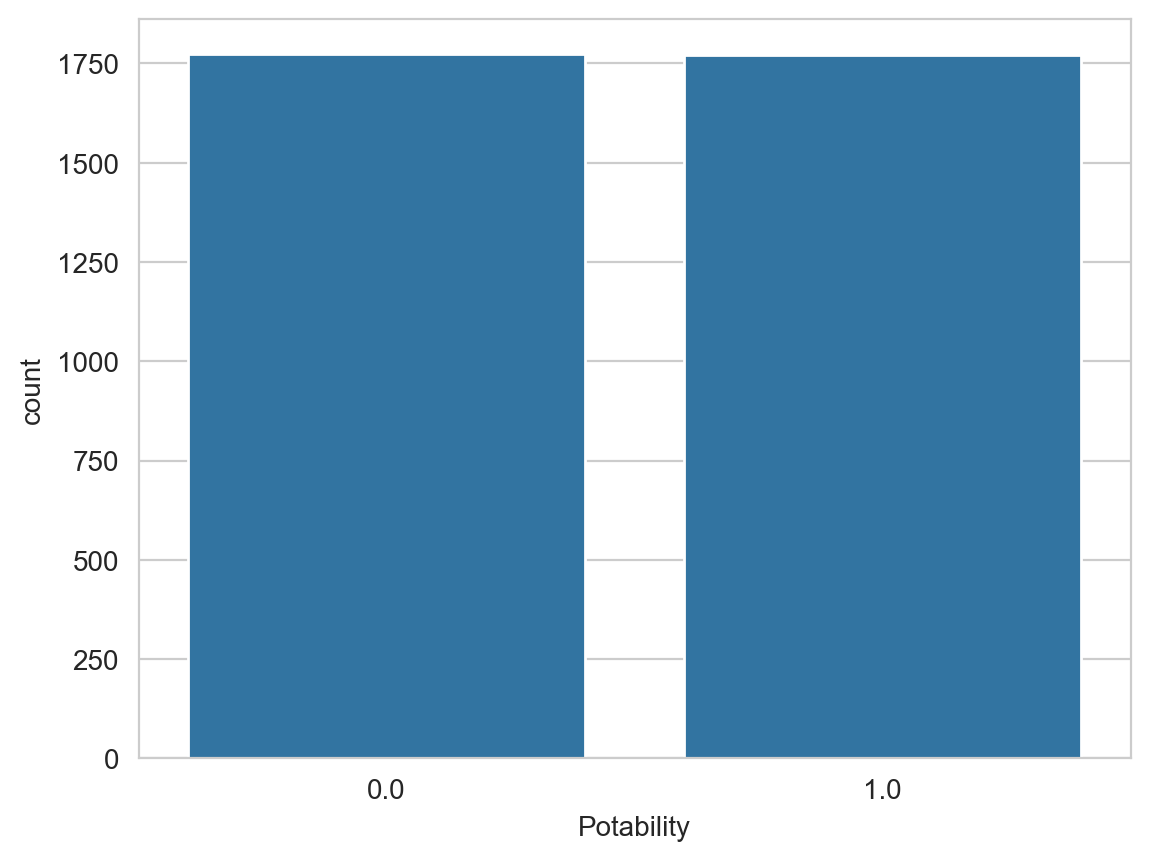

In [31]:
sns.countplot(x='Potability', data=df_cleaned)
plt.show()

## Balanceo de datos

In [33]:
# Selecting features (independent variables) and the target variable (dependent variable)
features = df_cleaned.drop('Potability', axis=1)
labels = df_cleaned['Potability']

# Creating arrays for features and labels
features_space = features
labels_space = labels.values

# Selecting 200 random samples from the dataset
random_values = features_space.sample(n=10)
X_sample = random_values.values
y_sample = labels_space[random_values.index]

# Instantiating the RandomOverSampler with random_state=0
oversampler = RandomOverSampler(random_state=0)

# Performing random oversampling to balance the dataset
X_resampled, y_resampled = oversampler.fit_resample(X_sample, y_sample)

## Divición de datos

In [34]:
# Rounding the values in X_resampled to 2 decimal places
X_resampled_rounded = np.round(X_resampled, 2)

# Splitting the rounded data into training and validation sets
# test_size=0.2 specifies that 20% of the data will be used for validation
# random_state=42 sets the random seed for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X_resampled_rounded, 
                                                  y_resampled, 
                                                  test_size=0.2, 
                                                  random_state=42)

# Printing the shapes of the training and validation sets
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

X_train shape: (9, 9)
X_val shape: (3, 9)


## Conversión de imagenes

In [35]:
# Converting the numerical training data into images
train_images = data_to_image(X_train)

# Converting the numerical validation data into images
val_images = data_to_image(X_val)

In [39]:
# Converting the training images to PyTorch tensors
X_train_I = torch.from_numpy(train_images).float()

# Converting the training labels to PyTorch tensors
y_train_I = torch.from_numpy(y_train).long()

# Converting the validation images to PyTorch tensors
X_val_I = torch.from_numpy(val_images).float()

# Converting the validation labels to PyTorch tensors
y_val_I = torch.from_numpy(y_val).long()

In [40]:
# Creating PyTorch datasets for training and validation
train_dataset = TensorDataset(X_train_I, y_train_I)
val_dataset = TensorDataset(X_val_I, y_val_I)

# Creating data loaders for training and validation sets
# The DataLoader class provides an iterable over the dataset, with optional shuffling and batching
dataloaders = {'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
               'val': DataLoader(val_dataset)}

# Storing the sizes of the training and validation datasets
dataset_sizes = {'train': len(X_train),
                 'val': len(X_val)}

## Modeling: By [AHN MINJAE](https://github.com/EmjayAhn/SuperTML-pytorch)

In [41]:
# Moving the pre-defined model to the specified device (GPU if available, otherwise CPU)
model = model_res.to(device)

# Defining the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Defining the optimizer (Adam optimizer) and passing model parameters to be optimized
optimizer = optim.Adam(model.parameters())

In [42]:
best_model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, device, 30)

EPOCH 1/1:
----------
train Loss: 1.0407 Acc: 0.5556
val Loss: 1.0401 Acc: 0.6667

Training completed in 0m 3s
BEST VALIDATION ACCURACY: 0.6667


# **T1**

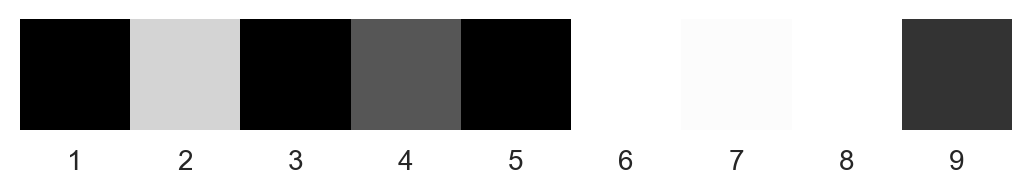

In [44]:
# Convertir los datos a mapas de calor en escala de grises
train_heatmaps_bw = data_to_heatmap_bw(X_train)
val_heatmaps_bw = data_to_heatmap_bw(X_val)

In [45]:
print('Forma de train_heatmaps_bw:', train_heatmaps_bw.shape)
print('Forma de val_heatmaps_bw:', val_heatmaps_bw.shape)

Forma de train_heatmaps_bw: (9, 480, 640, 4)
Forma de val_heatmaps_bw: (3, 480, 640, 4)


In [46]:
# Converting the training images to PyTorch tensors
X_train_II = torch.from_numpy(train_heatmaps_bw).float()

# Converting the training labels to PyTorch tensors
y_train_II = torch.from_numpy(y_train).long()

# Converting the validation images to PyTorch tensors
X_val_II = torch.from_numpy(val_heatmaps_bw).float()

# Converting the validation labels to PyTorch tensors
y_val_II = torch.from_numpy(y_val).long()

In [47]:
X_train_II = torch.from_numpy(train_heatmaps_bw).float()
X_val_II = torch.from_numpy(val_heatmaps_bw).float()

In [48]:
train_heatmaps_bw = np.mean(train_heatmaps_bw, axis=3)
val_heatmaps_bw = np.mean(val_heatmaps_bw, axis=3)

In [49]:
print('Tamaño de X_train_II - batch_size:', X_train_II.size(0))
print('Tamaño de X_train_II - canales:', X_train_II.size(1))
print('Tamaño de X_train_II - altura:', X_train_II.size(2))
print('Tamaño de X_train_II - ancho:', X_train_II.size(3))

Tamaño de X_train_II - batch_size: 9
Tamaño de X_train_II - canales: 480
Tamaño de X_train_II - altura: 640
Tamaño de X_train_II - ancho: 4


## Model CNN

In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convertir los mapas de calor a tensores de PyTorch
X_train_tensor = torch.from_numpy(train_heatmaps_bw).unsqueeze(1).float()
X_val_tensor = torch.from_numpy(val_heatmaps_bw).unsqueeze(1).float()

# Crear conjuntos de datos y cargadores de datos
train_dataset = TensorDataset(X_train_tensor, y_train_II)
val_dataset = TensorDataset(X_val_tensor, y_val_II)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Definir las capas convolucionales y de pooling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Definir las capas completamente conectadas
        self.fc1 = nn.Linear(32 * 120 * 160, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 clases (potable, no potable)

    def forward(self, x):
        # Aplicar convoluciones y funciones de activación
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Aplanar la salida de las capas convolucionales
        x = x.view(-1, 32 * 120 * 160)
        # Aplicar capas completamente conectadas
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instanciar el modelo
model = SimpleCNN()

In [54]:
import time  # Importa el módulo time
import torch.optim as optim
import torch.nn as nn

# Supongo que model, train_loader, y val_loader ya están definidos

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
best_val_accuracy = 0.0  # Variable para rastrear el mejor rendimiento de validación

for epoch in range(epochs):
    start_time = time.time()  # Inicia el contador de tiempo al inicio de la época
    
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    # Validación del modelo
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    epoch_time = time.time() - start_time  # Calcula el tiempo transcurrido al final de la época

    print(f'EPOCH {epoch+1}/{epochs}:')
    print('-' * 10)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')
    print(f'Epoch Time: {epoch_time:.2f} seconds\n')  # Imprime el tiempo transcurrido

    # Actualización del mejor rendimiento de validación
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

print(f'BEST VALIDATION ACCURACY: {best_val_accuracy:.4f}')


EPOCH 1/1:
----------
Train Loss: 0.6965 Acc: 0.4444
Val Loss: 79.8803 Acc: 0.3333
Epoch Time: 3.64 seconds

BEST VALIDATION ACCURACY: 0.3333


# **T2**

## Images GG - Vit

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import torch
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import warnings

In [57]:
train_images_gg = gray_gang_gg(X_train)
val_images_gg = gray_gang_gg(X_val)

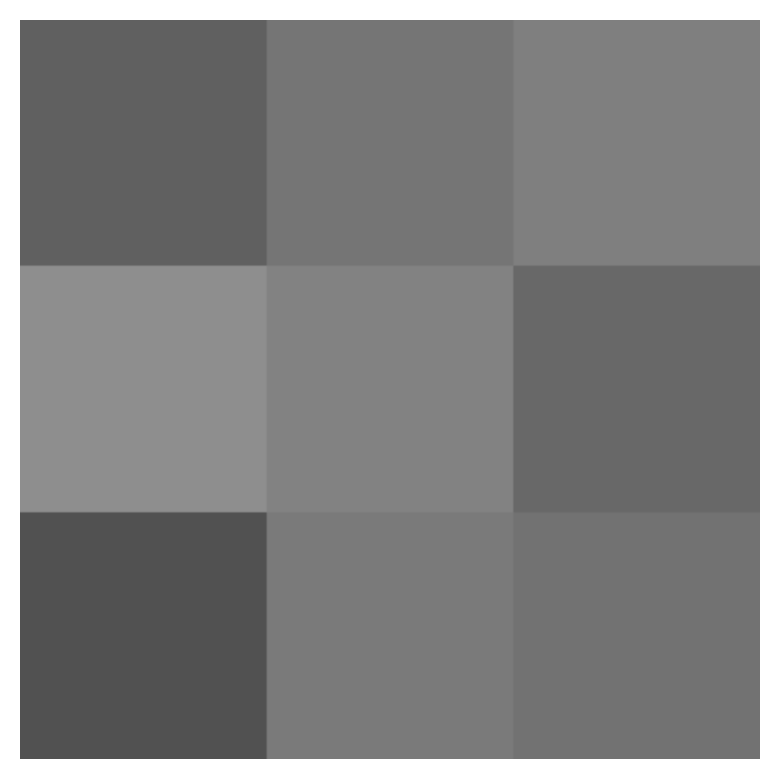

In [60]:
image = train_images_gg[2]

if isinstance(image, torch.Tensor):
    image = image.numpy()

if image.shape[0] == 3:  
    image = np.transpose(image, (1, 3, 0))
    
plt.imshow(image)
plt.axis('off') 
plt.show()

In [61]:
class PotabilityDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [62]:
# Transformaciones para el dataset
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [63]:
train_dataset = PotabilityDataset(train_images_gg, y_train, transform=transform)
val_dataset = PotabilityDataset(val_images_gg, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [64]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [65]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [70]:
train_model_Vit(model, train_loader, val_loader, criterion, optimizer, 30)

Epoch 1/1:
Train Loss: 0.6916200518608093
Validation Accuracy: 0.3333333333333333
----------
Training completed.
BEST VALIDATION ACCURACY: 0.3333


# **T3** (Working)

## PCA con ResNet

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image, ImageDraw
import numpy as np
from sklearn.decomposition import PCA


In [85]:
from transformers import DistilBertTokenizer, DistilBertModel

from sklearn.decomposition import PCA
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [86]:
train_images = data_to_image_pca(X_train)
val_images = data_to_image_pca(X_val)

In [87]:
class PotabilityDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [88]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [89]:
train_dataset = PotabilityDataset(train_images, y_train, transform=transform)
val_dataset = PotabilityDataset(val_images, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [90]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Assuming binary classification
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [91]:
# Modelo de transformers
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [92]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [93]:
def train_model_1(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {running_loss/len(train_loader)}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            print(f"Validation Accuracy: {val_accuracy}")
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

        print('-' * 10)

    print("Training completed.")
    print(f"BEST VALIDATION ACCURACY: {best_val_accuracy:.4f}")

In [95]:
train_model_1(model, train_loader, val_loader, criterion, optimizer)

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)